In [1]:
from pathlib import Path
from tifffile import imread, imwrite
import numpy as np
import sys
import json
from stardist.matching import matching_dataset
sys.path.append("../")
from utils import *
from plots import *

SAVE_AS_SVG = True
SAVE_AS_PNG = False

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
DATA_PATH = Path.home() / "Desktop/Code/CELLSEG_BENCHMARK/RESULTS/SUPERVISED_PERF_FIG/TRAINING"
gt_path = DATA_PATH / "dataset_float32/labels/semantic"

folds = 3
# stardist_path = Path("E:/Code/CELLSEG_BENCHMARK/SUPERVISED_PERF_FIG/TRAINING").resolve()
# models_pred_path = [(stardist_path / f"fold{i+1}").resolve() for i in range(folds)] 
models_pred_path = [(DATA_PATH / f"fold{i+1}").resolve() for i in range(folds)] 

In [4]:
gt_images = {}
# load images in gt_path
for img_path in gt_path.glob("*.tif"):
    img = imread(img_path)
    gt_images[img_path.stem[:2]] = img

In [5]:
# for each fold and model, the goal is to compute what is the best threshold for the model, based on Dice between the GT and the prediction
dices_df = pd.DataFrame(columns=["Image", "Threshold", "NMS", "Dice", "Fold"])
for model_pred_path in models_pred_path:
    print("Fold : ", model_pred_path.name)
    preds_path = model_pred_path / "stardist" 
    for i, img_path in enumerate(preds_path.glob("*.tif")):
        img_name = img_path.stem
        print(f"Image: {img_name[:2]}")
        img = imread(img_path)
        gt = gt_images[img_name[:2]]
        nms = float(img_path.stem.split("_nms_")[1].split("_prob_")[0])
        prob_thresh = float(img_path.stem.split("_prob_")[1])
        print("Threshold: ", prob_thresh)
        print("NMS: ", nms)
        # gt = np.where(gt > 0, 1, 0) 3 already semantic
        pred = np.where(img > 0, 1, 0)
        dice = dice_coeff(y_true=gt, y_pred=pred)
        dices_df.loc[len(dices_df.index)] = [img_name[:2], prob_thresh, nms, dice, model_pred_path.name]

Fold :  fold1
Image: c1
Threshold:  0.1
NMS:  0.1
Image: c1
Threshold:  0.2
NMS:  0.1
Image: c1
Threshold:  0.3
NMS:  0.1
Image: c1
Threshold:  0.4
NMS:  0.1
Image: c1
Threshold:  0.5
NMS:  0.1
Image: c1
Threshold:  0.6
NMS:  0.1
Image: c1
Threshold:  0.7
NMS:  0.1
Image: c1
Threshold:  0.8
NMS:  0.1
Image: c1
Threshold:  0.9
NMS:  0.1
Image: c1
Threshold:  0.1
NMS:  0.2
Image: c1
Threshold:  0.2
NMS:  0.2
Image: c1
Threshold:  0.3
NMS:  0.2
Image: c1
Threshold:  0.4
NMS:  0.2
Image: c1
Threshold:  0.5
NMS:  0.2
Image: c1
Threshold:  0.6
NMS:  0.2
Image: c1
Threshold:  0.7
NMS:  0.2
Image: c1
Threshold:  0.8
NMS:  0.2
Image: c1
Threshold:  0.9
NMS:  0.2
Image: c1
Threshold:  0.1
NMS:  0.3
Image: c1
Threshold:  0.2
NMS:  0.3
Image: c1
Threshold:  0.3
NMS:  0.3
Image: c1
Threshold:  0.4
NMS:  0.3
Image: c1
Threshold:  0.5
NMS:  0.3
Image: c1
Threshold:  0.6
NMS:  0.3
Image: c1
Threshold:  0.7
NMS:  0.3
Image: c1
Threshold:  0.8
NMS:  0.3
Image: c1
Threshold:  0.9
NMS:  0.3
Image: c1
Thre

In [6]:
dices_df.sort_values(by="Threshold", inplace=True)
dices_df

,Image,Threshold,NMS,Dice,Fold
0,c1,0.1,0.1,0.487222,fold1
963,c2,0.1,0.9,0.424142,fold3
252,c4,0.1,0.2,0.503017,fold1
693,c4,0.1,0.6,0.657963,fold2
522,c2,0.1,0.5,0.667139,fold2
...,...,...,...,...,...
746,vi,0.9,0.2,0.000013,fold2
1052,c4,0.9,0.9,0.014901,fold3
161,c2,0.9,0.9,0.478175,fold1
98,c2,0.9,0.2,0.495884,fold1


In [7]:
dices_df.groupby("Fold").apply(lambda x: x.loc[x["Dice"].idxmax()])

971282983.py (1): DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


,Image,Threshold,NMS,Dice,Fold
Fold,,,,,
fold1,c5,0.8,0.5,0.560387,fold1
fold2,vi,0.5,0.7,0.690538,fold2
fold3,c5,0.6,0.4,0.628781,fold3


In [8]:
# show 3 best Dice for each fold
dices_df.groupby("Fold").apply(lambda x: x.nlargest(3, "Dice"))

327610266.py (2): DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.


Image  Threshold  NMS      Dice   Fold
Fold                                             
fold1 367     c5        0.8  0.5  0.560387  fold1
      376     c5        0.8  0.6  0.560232  fold1
      385     c5        0.8  0.7  0.559902  fold1
fold2 787     vi        0.5  0.7  0.690538  fold2
      778     vi        0.5  0.6  0.689971  fold2
      797     vi        0.6  0.8  0.688972  fold2
fold3 1085    c5        0.6  0.4  0.628781  fold3
      1112    c5        0.6  0.7  0.628514  fold3
      1094    c5        0.6  0.5  0.628482  fold3

In [9]:
dices_df.groupby("Threshold").Dice.median().sort_values(ascending=False).head(5)

Threshold
0.7    0.589936
0.6    0.585618
0.8    0.582878
0.5    0.580061
0.4    0.578235
Name: Dice, dtype: float64

In [10]:
dices_df.groupby("NMS").Dice.median().sort_values(ascending=False).head(5)

NMS
0.3    0.577093
0.2    0.575638
0.4    0.572878
0.1    0.572404
0.5    0.570113
Name: Dice, dtype: float64

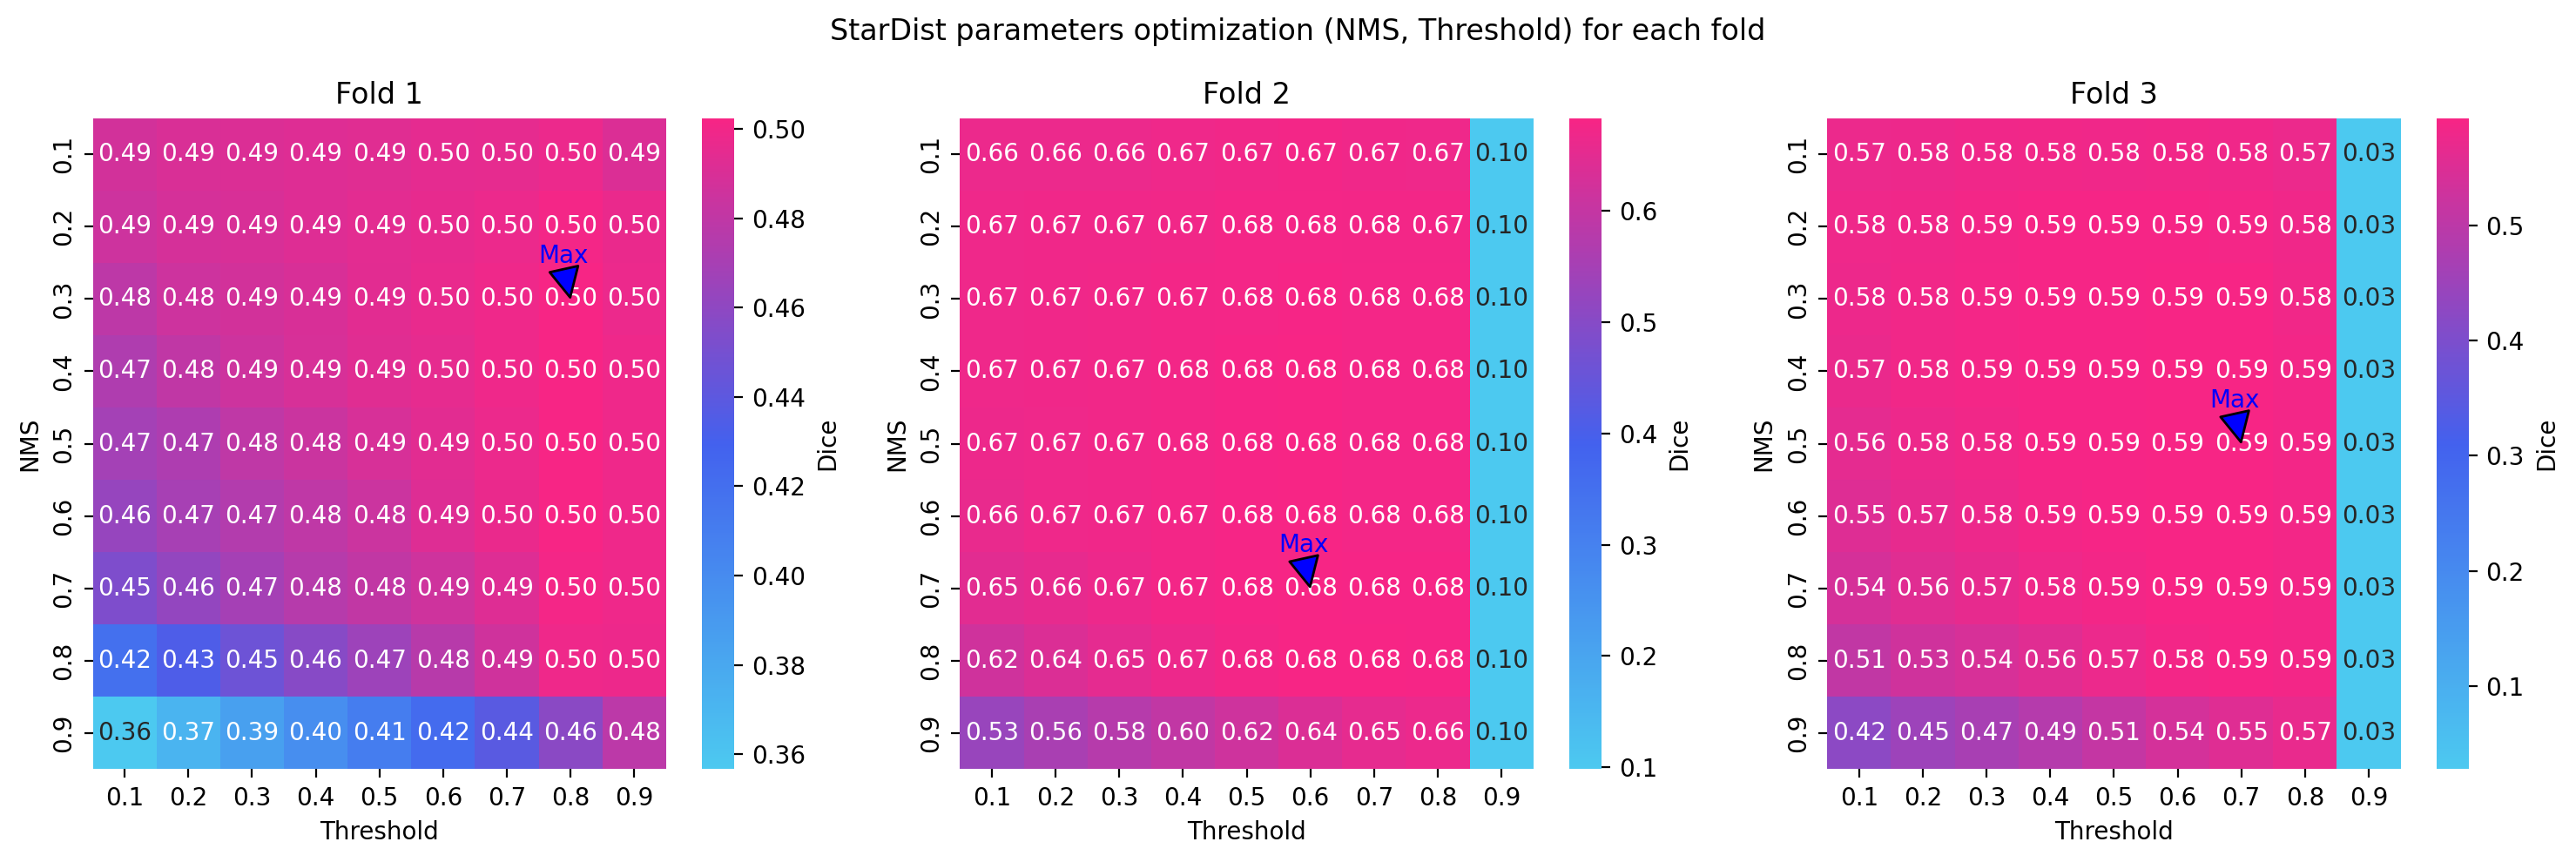

<Figure size 640x480 with 0 Axes>

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5), dpi=DPI)
for i in range(folds):
    # Group by 'NMS' and 'Threshold' and calculate the mean of 'Dice' for fold i
    grouped_df = dices_df[dices_df['Fold'] == f"fold{i+1}"].groupby(['NMS', 'Threshold'])['Dice'].median().reset_index()

    pivot_df = grouped_df.pivot(index='NMS', columns='Threshold', values='Dice')
    max_coords = np.where(pivot_df == pivot_df.max().max())
    sns.heatmap(pivot_df, cmap=SEQUENTIAL_COLORMAP, annot=True, fmt=".2f", cbar_kws={'label': 'Dice'}, ax=axs[i])
    # Annotate the maximum value
    axs[i].annotate('Max', xy=(max_coords[1][0]+0.5, max_coords[0][0]+0.5), xytext=(max_coords[1][0], max_coords[0][0]),
                arrowprops=dict(facecolor='blue', shrink=0.05), color='blue')
    axs[i].set_title(f"Fold {i+1}")
plt.suptitle("StarDist parameters optimization (NMS, Threshold) for each fold")
plt.tight_layout()
plt.show()
if SAVE_AS_SVG:
    plt.savefig(DATA_PATH / "stardist_optimization_grid_search.svg", format="svg", bbox_inches='tight')
if SAVE_AS_PNG:
    plt.savefig(DATA_PATH / "stardist_optimization_grid_search.png", format="png")

In [12]:
# for each fold, compare found parameters with auto-estimated thresholds
labels = []
names = []
gt_labels = []

for fold in range(3):
    fold_path = DATA_PATH / f"../INFERENCE/fold{fold+1}/stardist"
    auto_path = list((fold_path / "old").glob("*.tif"))[0]
    manual_path = list((fold_path).glob("*.tif"))[0]
    labels.append(imread(auto_path))
    print(auto_path.stem)
    names.append(f"Fold {fold+1} - Auto - {auto_path.stem}")
    print(manual_path.stem)
    labels.append(imread(manual_path))
    names.append(f"Fold {fold+1} - Manual - {manual_path.stem}")
    
    labels_gt_path = (fold_path / "..").resolve()
    for img_path in labels_gt_path.glob("*.tif"):
        if "label" in img_path.stem:
            print(img_path.stem)
            gt_labels.append(imread(img_path))
            gt_labels.append(imread(img_path))
            break
    print("-"*10)

IndexError: list index out of range

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

model_stats = {}
names_stats = {}

for i, p in enumerate(labels):
    print(f"Validating on {names[i]}")
    fold = int(names[i].split(" ")[1].split("-")[0])
    model_stats[f"fold{fold}"] = [] if f"fold{fold}" not in model_stats else model_stats[f"fold{fold}"]
    names_stats[f"fold{fold}"] = [] if f"fold{fold}" not in names_stats else names_stats[f"fold{fold}"]
    if len(p.shape) > 3:
        p = p[0].astype(np.uint64)
    stats = [matching_dataset(
        gt_labels[i], 
        p,
        thresh=t, 
        show_progress=False
        ) for t in taus]
    model_stats[f"fold{fold}"].append(stats)
    names_stats[f"fold{fold}"].append(f"{names[i]}")
    print("*"*20)

Validating on Fold 1 - Auto - visual_stardist_labels
********************
Validating on Fold 1 - Manual - stardist_fold1
********************
Validating on Fold 2 - Auto - c5_stardist
********************
Validating on Fold 2 - Manual - stardist_fold2
********************
Validating on Fold 3 - Auto - c3_labels_stardist
********************
Validating on Fold 3 - Manual - stardist_fold3
********************


In [ ]:
# get cellpose_count first color of tab20 as rgb hex
sd_color = get_n_shades(COLORMAP[0], n_shades=6)
sd_color

['#000000', '#102A33', '#205566', '#308099', '#40AACC', '#50D5FF']

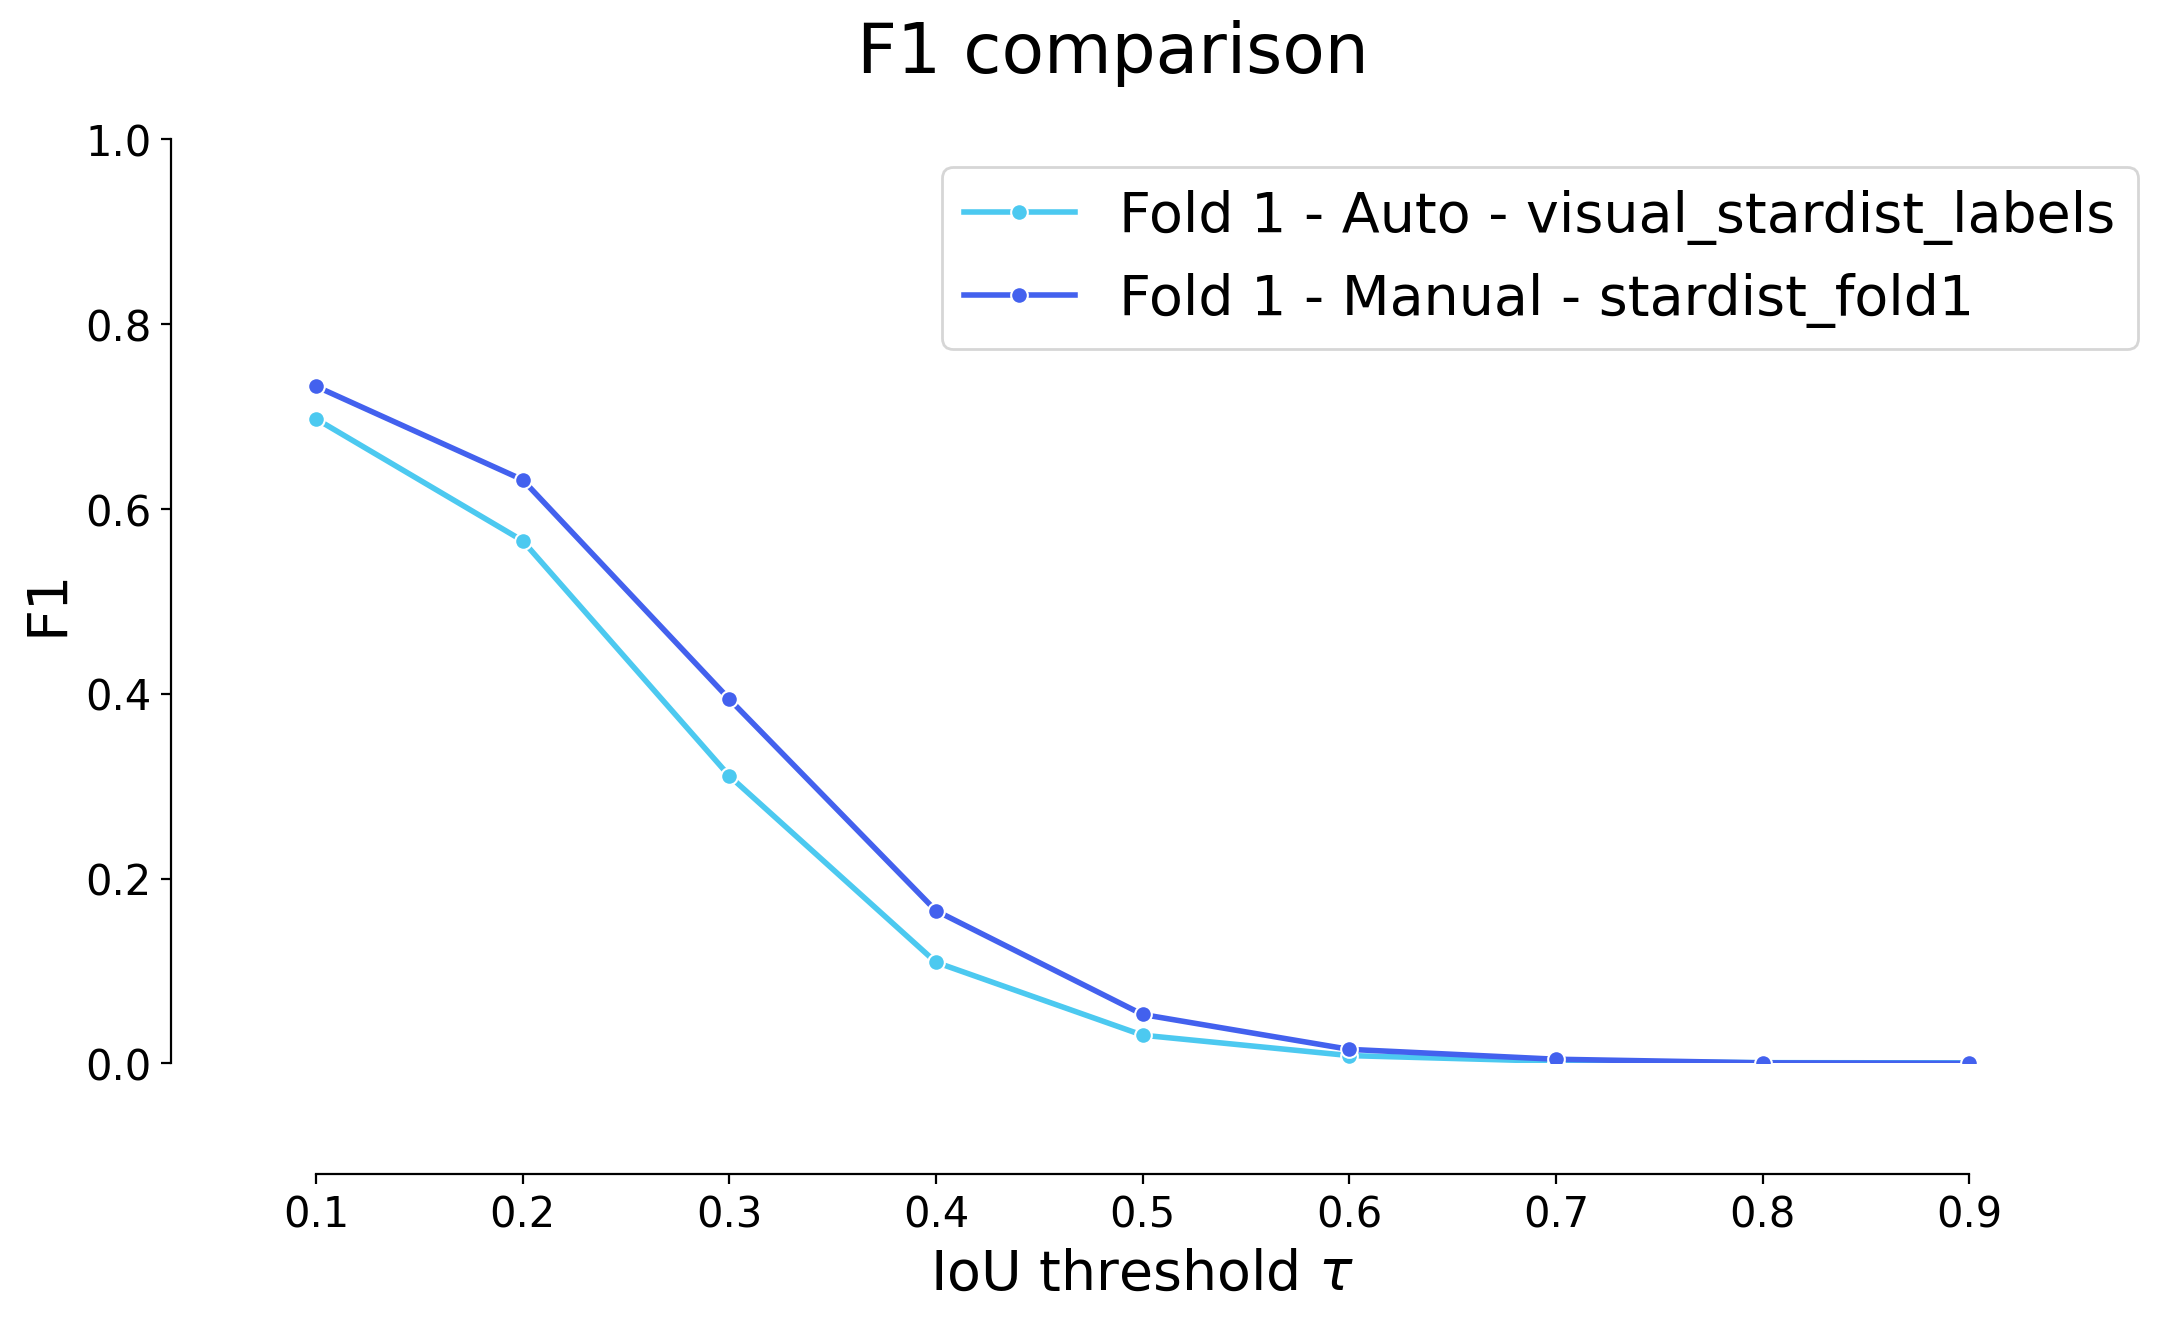

In [ ]:
plot_stat_comparison(taus=taus, stats_list=model_stats["fold1"], model_names=names_stats["fold1"], metric="IoU", colormap=COLORMAP)
plt.show()
if SAVE_AS_SVG:
    plt.savefig("stardist_auto_vs_manual_fold1_iou.svg", format="svg", bbox_inches='tight')
if SAVE_AS_PNG:
    plt.savefig("stardist_auto_vs_manual_fold1_iou.png", format="png")

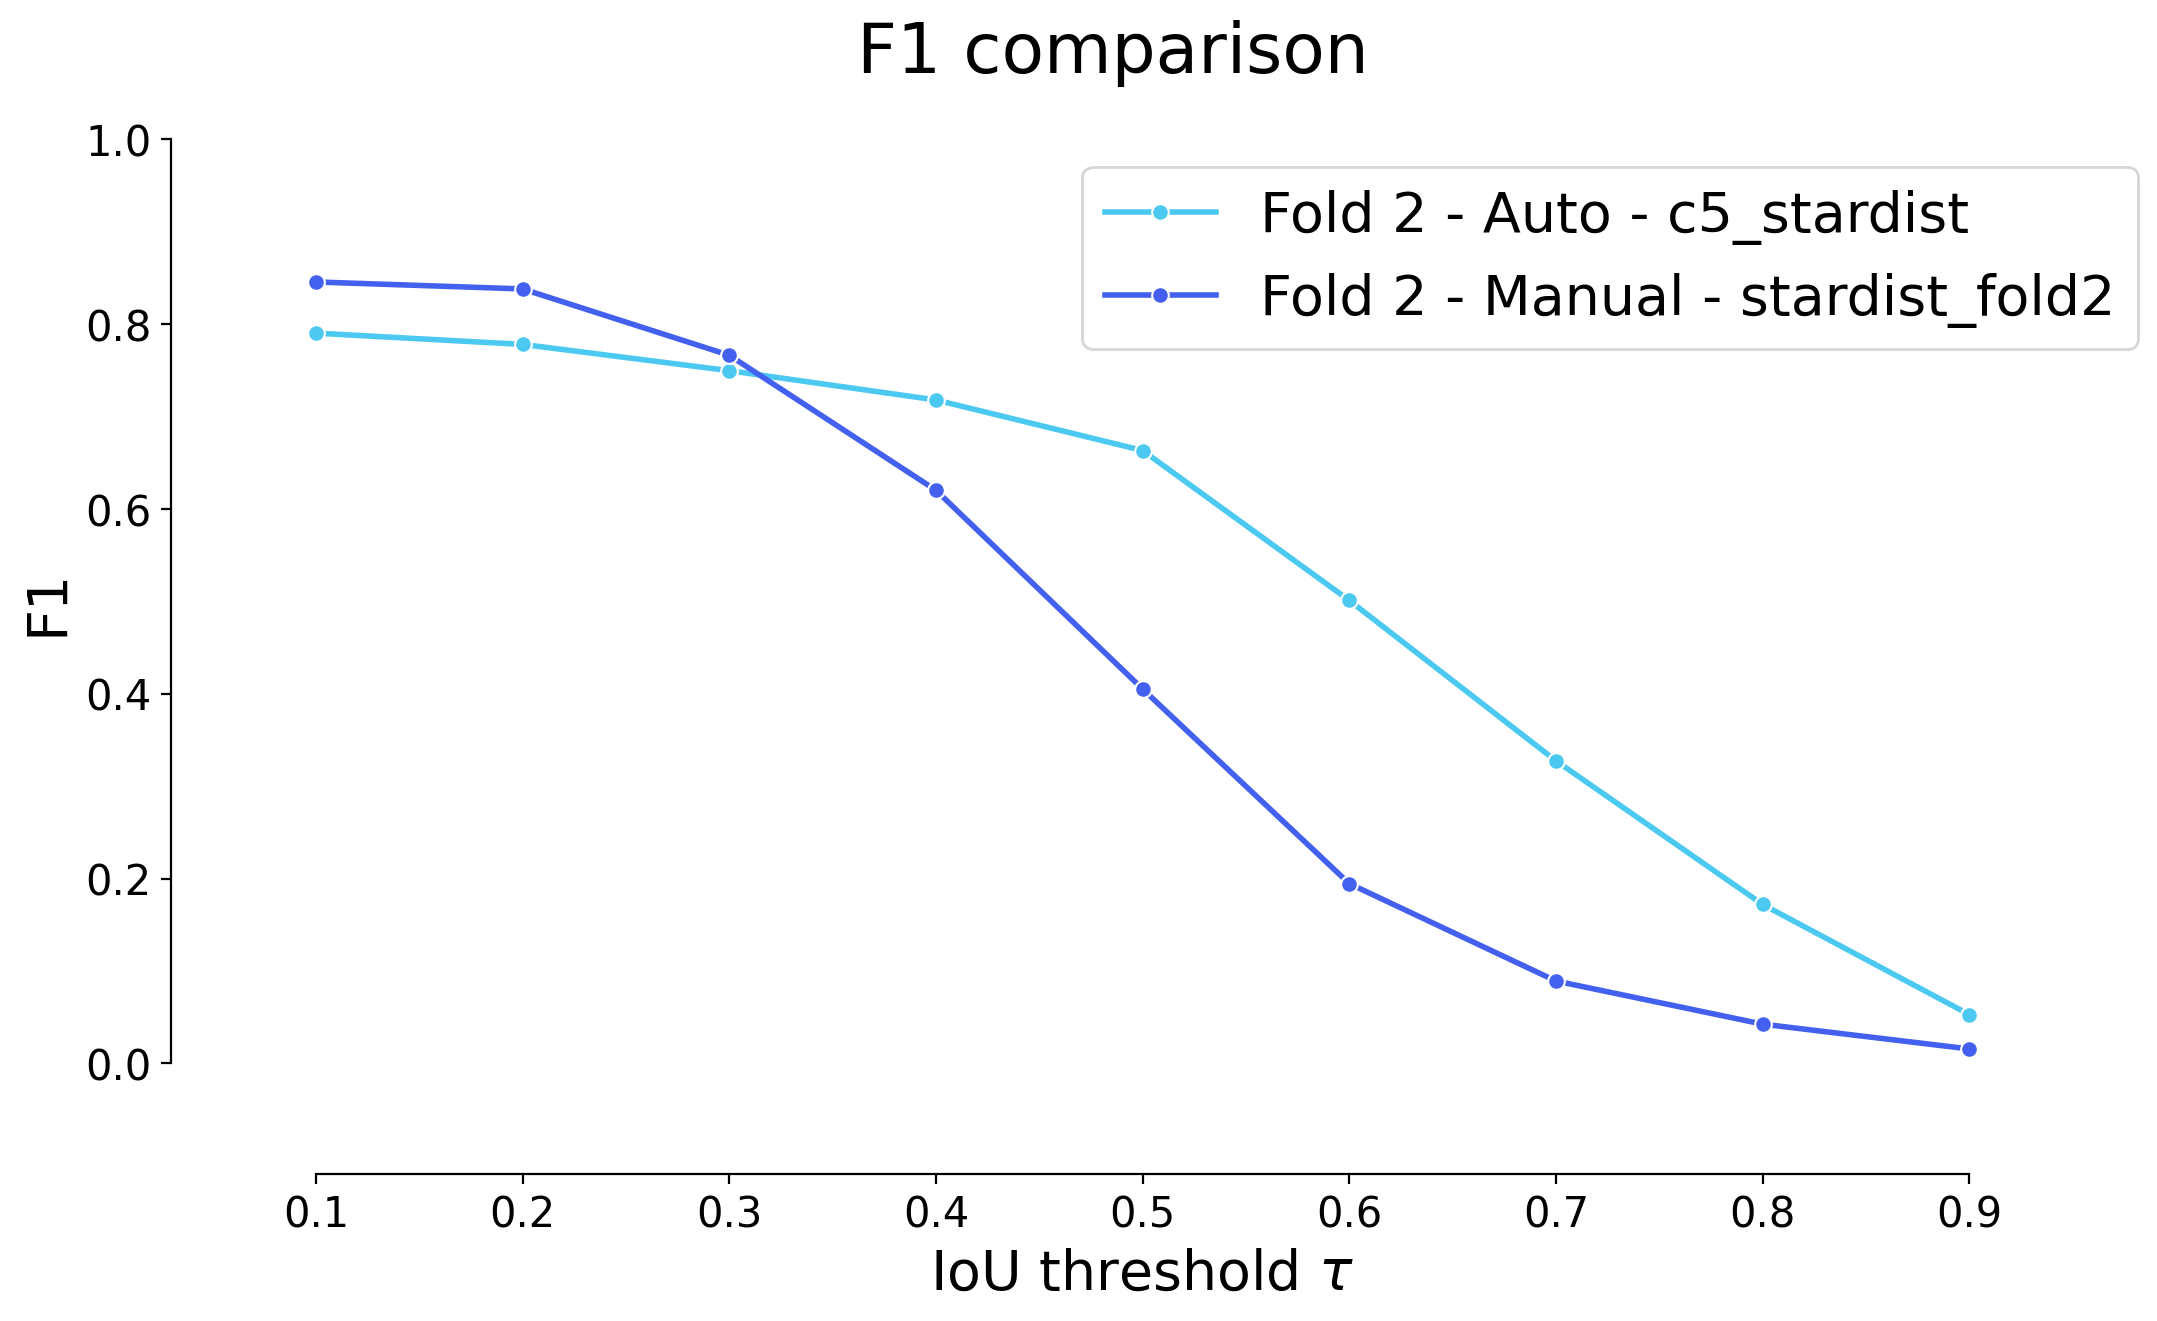

In [ ]:
plot_stat_comparison(taus=taus, stats_list=model_stats["fold2"], model_names=names_stats["fold2"], metric="IoU", colormap=COLORMAP)
if SAVE_AS_SVG:
    plt.savefig("stardist_auto_vs_manual_fold2_iou.svg", format="svg", bbox_inches='tight')
if SAVE_AS_PNG:
    plt.savefig("stardist_auto_vs_manual_fold2_iou.png", format="png")

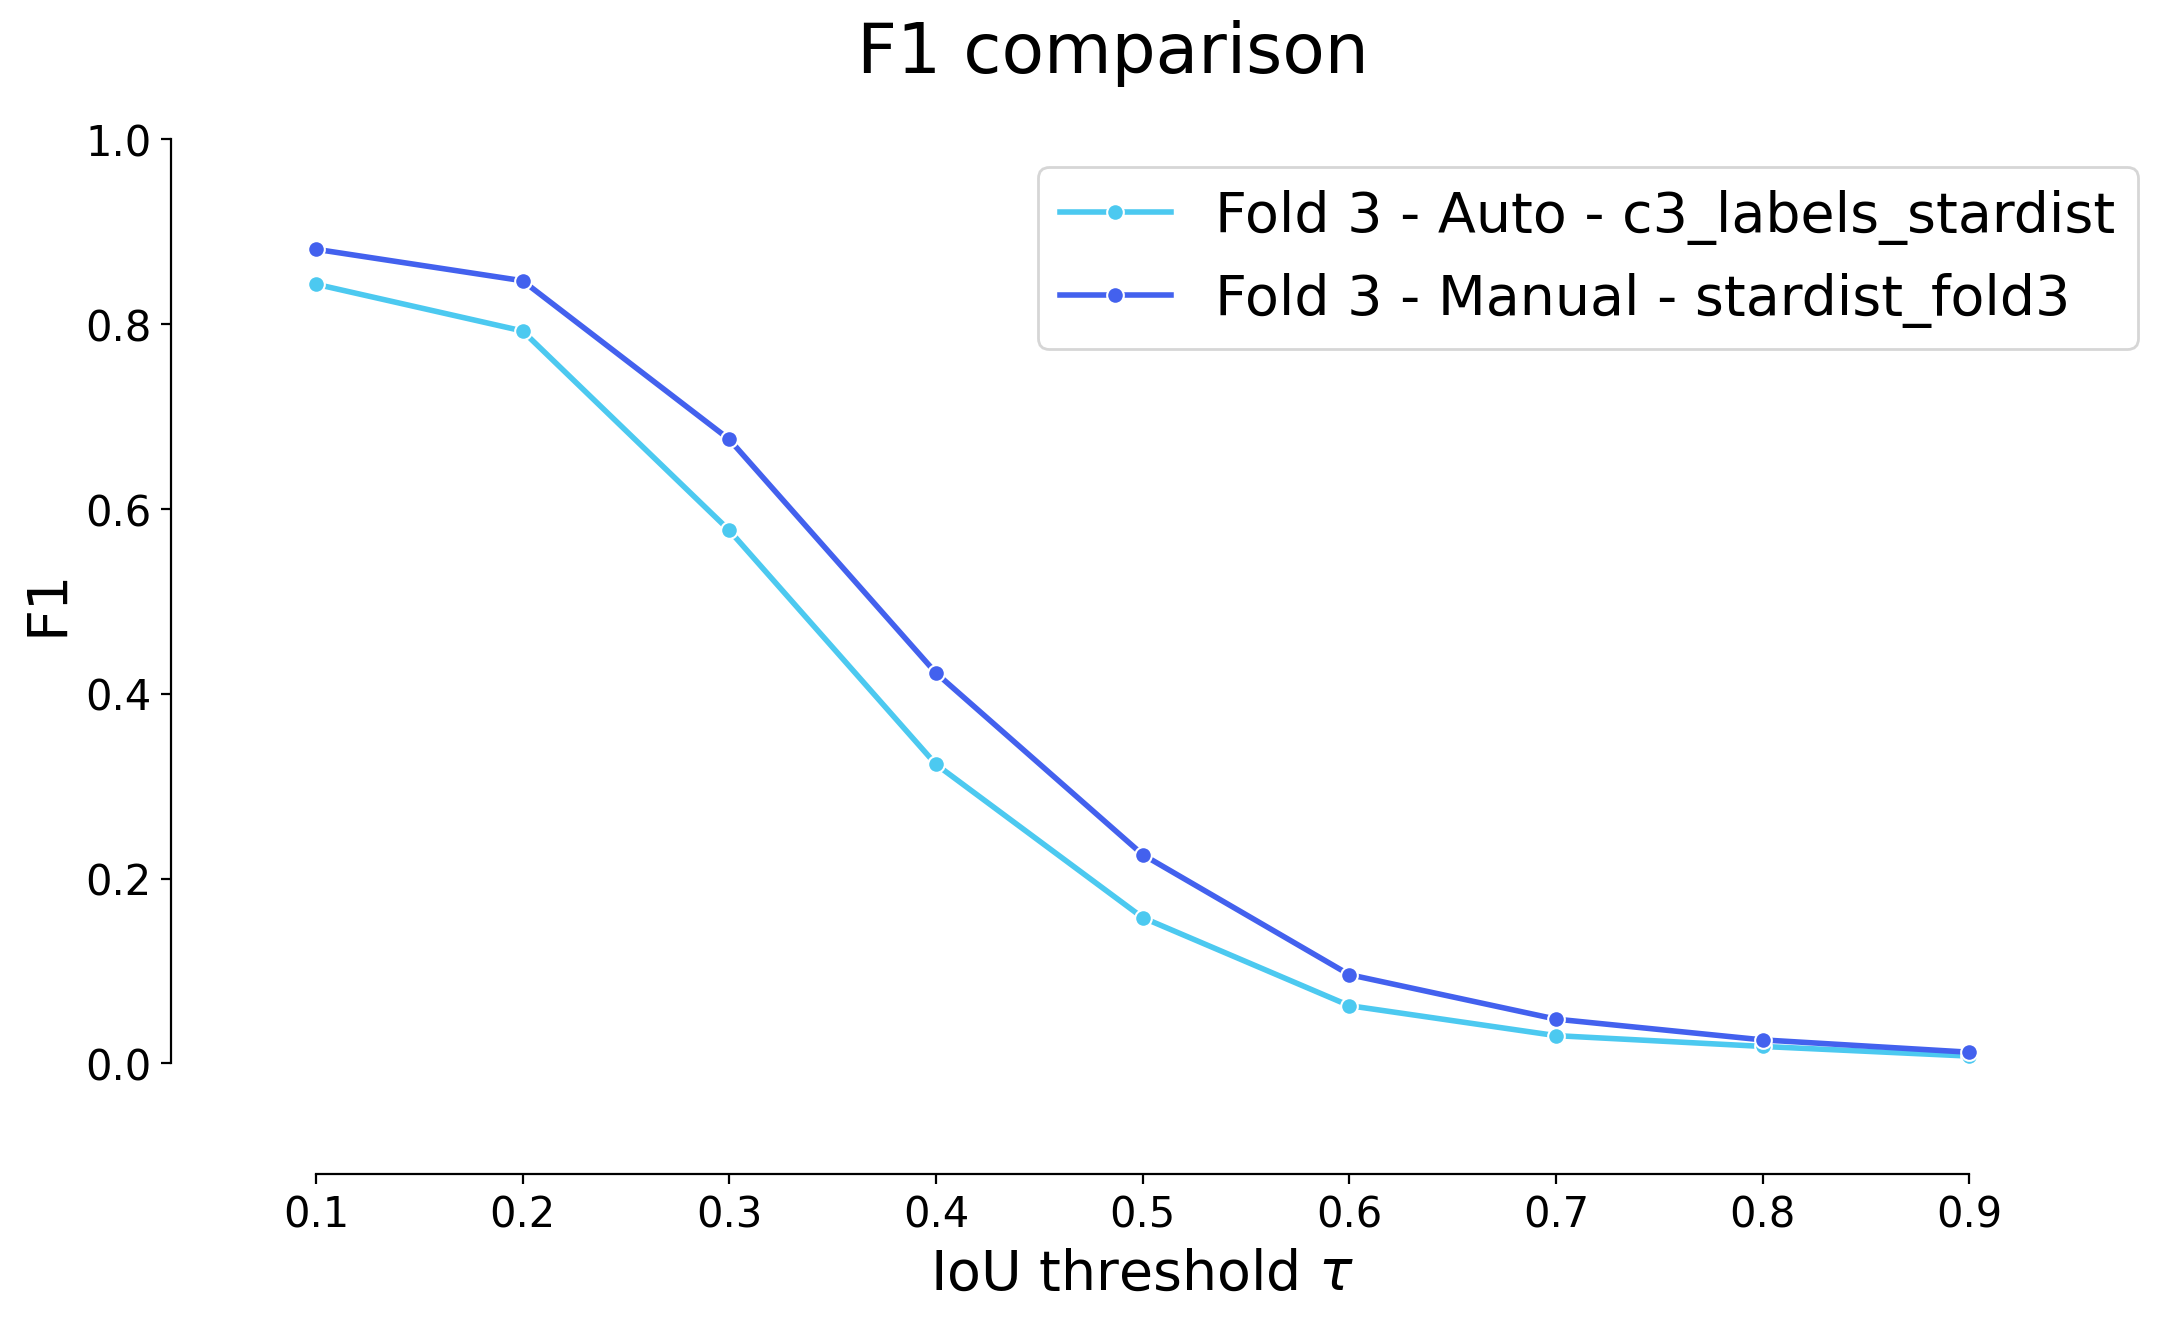

In [ ]:
plot_stat_comparison(taus=taus, stats_list=model_stats["fold3"], model_names=names_stats["fold3"], metric="IoU", colormap=COLORMAP)
if SAVE_AS_SVG:
    plt.savefig("stardist_auto_vs_manual_fold3_iou.svg", format="svg", bbox_inches='tight')
if SAVE_AS_PNG:
    plt.savefig("stardist_auto_vs_manual_fold3_iou.png", format="png")